# Mini neural net training
Authors: Alfredo Canziani, Philipp Schmitt  
Date: Fri 14 Feb 2020

In [34]:
import torch
from torch import nn, optim
from IPython import display
from PIL import Image, ImageFont, ImageDraw
from matplotlib.pyplot import imshow, axis, figure, subplot, pause
import numpy
import random

%matplotlib inline

In [35]:
# static random seed
torch.manual_seed(0)

In [36]:
# Input definition
class input_settings:
    batch_size = 1
    channels = 1
    height = 8
    width = 8

dummy_X = torch.randn(  # batch of inputs x
    input_settings.batch_size,
    input_settings.channels,
    input_settings.height,
    input_settings.width,
)

In [37]:
# Network architecture
class model_settings:
    conv_channels = 4
    kernel = 3
    pooling_kernel = 3
    flattened = 16
    output_size = 1
    
model = nn.Sequential(
    nn.Conv2d(
        in_channels=input_settings.channels,
        out_channels=model_settings.conv_channels,
        kernel_size=model_settings.kernel,
        bias=True,
    ),
    nn.ReLU(),
    nn.MaxPool2d(
        kernel_size=model_settings.pooling_kernel,
        stride=model_settings.pooling_kernel,
    ),  # we have 4 x 2x2
    nn.Flatten(),  # gives 16
    nn.Linear(
        in_features=model_settings.flattened,
        out_features=model_settings.output_size,
        bias=True,
    ),
)

In [38]:
# Inference
with torch.no_grad():
    print(model(dummy_X).size())

torch.Size([1, 1])


In [39]:
# Print the model architecture
print(model)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [40]:
# Get weights and biases
def get_weights():
    print(
        model[0],
        model[0].weight,
        model[0].bias,
        sep='\n',
    )
    print(
        model[4],
        model[4].weight,
        model[4].bias,
        sep='\n',
    )
    # Maybe add some saving routines

In [41]:
font = ImageFont.truetype('Verdana', 8)  # let's keep it to Verdana 8pt
data_set_settings = dict(
    D=dict(
        x_min = -1,
        x_max = 2,
        y_min = -3,
        y_max = -1,
    ),
    C=dict(
        x_min = 0,
        x_max = 3,
        y_min = -4,
        y_max = -2,
    )
)

In [42]:
def generate_data(visualise=False, target=None):
    image = Image.new('L', (input_settings.height, input_settings.width))
    draw = ImageDraw.Draw(image)
    draw.fontmode = '1'
    if not target:
        character = random.choice(('C', 'D'))
    else:
        character = target

    x = random.randint(
        data_set_settings[character]['x_min'],
        data_set_settings[character]['x_max'],
    )
    y = random.randint(
        data_set_settings[character]['y_min'],
        data_set_settings[character]['y_max'],
    )

    draw.text((x, y), character, (255,), font=font)
    data = numpy.array(image, dtype=numpy.float32) / 255
    
    if visualise:
        figure(facecolor='k')
        imshow(data, cmap='gray')
        axis('off');
    
    return torch.tensor(data).unsqueeze_(0), torch.tensor(character=='C', dtype=torch.float)

(tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 1., 1.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]), tensor(1.))

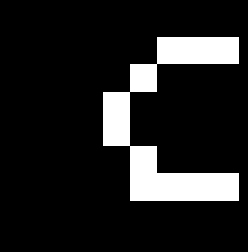

In [43]:
generate_data(visualise=True)

In [44]:
# Generate a C, D batch
def get_batch(visualise=False):
    Cx, Cy = generate_data(target='C', visualise=visualise)
    Dx, Dy = generate_data(target='D', visualise=visualise)
    x = torch.stack((Cx, Dx))
    y = torch.stack((Cy, Dy))
    return x, y

In [45]:
# Set up network training
nb_epochs = 10_000
optimiser = optim.SGD(params=model.parameters(), lr=1e-3)
loss = nn.BCEWithLogitsLoss()

D


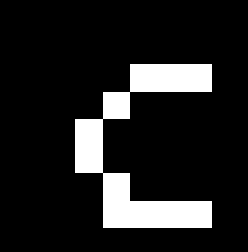

In [46]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=True)[0].unsqueeze_(0)) > 0 else 'D')

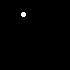

In [47]:
from PIL import Image, ImageDraw
from numpy import interp
from math import cos, sin, radians, pi


def draw_weight(value, size=20):
    rad = interp(value,[-.75,.75],[pi,0])
    im = Image.new('RGB', (size, size), (0, 0, 0))
    draw = ImageDraw.Draw(im)
    x, y, r = (
        size/2 + size/3 * cos(rad), 
        size/2 - size/3 * sin(rad),
        4)
    draw.ellipse((x-r/2, y-r/2, x+r/2, y+r/2), fill=(255, 255, 255), outline=None)

    return im

draw_weight(-.25, 70)

In [48]:
# draw weights

def draw_weights(layer, size=20):
    weights = layer.weight.data.clone().numpy()

    n_weights = len(weights[0])
    im = Image.new('RGB', ((size+1)*n_weights, size), (255, 255, 255))

    for i in range(n_weights):
        weight = draw_weight(weights[0][i], size=size)
        im.paste(weight,((size+1)*i,0))

    return im

draw_weights(model[4], size=30)

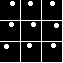

In [49]:
# draw a filter
def draw_filter(filter):
    matrix = Image.new('RGB', (63, 63), (255, 255, 255))
    data = filter.view(3, 3).numpy()
    # go over filter
    # rows
    for x in range(0, data.shape[0]):
        # cols
        for y in range(0, data.shape[1]):
            vis = draw_weight(data[y,x])
            matrix.paste(vis,(x*21,y*21))
    return matrix

filters = model[0].weight.data
draw_filter(filters[0])

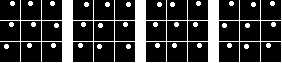

In [50]:
# draw all filters
def draw_filters(layer):
    matrix = Image.new('RGB', (282, 63), (255, 255, 255))
    filters = layer.weight.data.clone()
    for i, filter in enumerate(filters):
        vis = draw_filter(filter)
        matrix.paste(vis, (i*(63+10),0))
    return matrix


draw_filters(model[0])

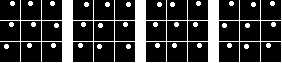

In [51]:
draw_filters(model[0])

In [52]:
#model[0].weight.data.fill_(0)
#model[4].weight.data.fill_(0)

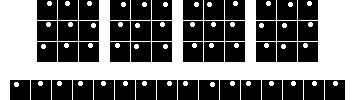

In [53]:
# draw all the weights in the net
def draw_net():
    im = Image.new('RGB', (356, 100), (255, 255, 255))
    im.paste(draw_filters(model[0]), (37,0))
    im.paste(draw_weights(model[4]), (10,80))

    return im

draw_net()

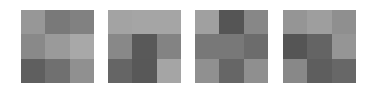

In [54]:
# Visualize weights
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    # visualize
    for i in range(0, len(filters)):
        data = filters[i].view(3, 3)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');
        
visualize_filters(model[0])

---
# Training

[EPOCH]: 9900, [LOSS]: 0.522867, [ACCURACY]: 1.000
tensor([[[[ 1.4405e-01, -4.0901e-04,  4.3509e-01],
          [-5.5977e-02, -3.8172e-02,  6.7312e-01],
          [-2.7486e-01, -2.3733e-01,  4.3573e-01]]],


        [[[ 5.9890e-01,  5.5453e-01,  7.6617e-01],
          [-2.4859e-01, -3.3467e-01, -2.8994e-01],
          [-3.9219e-01, -3.1880e-01,  1.1148e-01]]],


        [[[ 5.4940e-01, -3.5500e-01,  3.9897e-02],
          [-5.5662e-02, -2.9234e-01, -1.5600e-01],
          [ 4.5096e-02, -2.5738e-01, -1.3497e-01]]],


        [[[ 4.3571e-01,  4.2108e-01,  3.4907e-01],
          [-3.3318e-01, -2.4772e-01,  4.0894e-02],
          [ 2.9095e-02, -2.5912e-01, -2.1687e-01]]]])


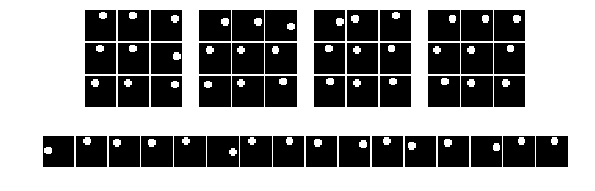

In [55]:
# Training
for epoch in range(nb_epochs):
    # Training steps
    X, Y = get_batch()
    logits = model(X).squeeze(1)  # feed-forward
    J = loss(logits, Y)  # computes the loss
    model.zero_grad()  # cleans up previous gradients
    J.backward()
    optimiser.step()
    
    # Accuracy computation and display
    score, predicted = torch.max(logits, 0)
    acc = (Y == (logits > 0)).sum().float() / len(Y)

    if(epoch % 100 == 0):
        display.clear_output(wait=True)
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, J.item(), acc))
        
        print(model[0].weight.data)
        
        figure(figsize=(10, 20))
        #visualize_filters(model[0])
        im = draw_net()
        imshow(numpy.asarray(im), aspect='equal', interpolation='nearest')
        
        # im.save('%s.png' % epoch)
        
        #draw_filters(model[0]).save('%i.png' % epoch)
        axis('off');
        pause(0.1)

In [24]:
# register hook to get activation after conv layer out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model[0].register_forward_hook(get_activation('act'))

C


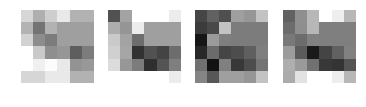

In [42]:
# Inference: C vs. D detector
with torch.no_grad():
    print('C' if model(generate_data(visualise=False)[0].unsqueeze_(0)) > 0 else 'D')
    #print(activation['act'])
    
    # visualize activations after convolution
    for i, act in enumerate(activation['act'][0]):
        data = act.view(6,6)
        subplot(1, 4, i+1)
        imshow(data, cmap='gray', vmin=-1, vmax=1)
        axis('off');